# Frame Analysis
This notebook calculates differences in word choice between Democrats and Republicans on a variety of political issues inductively identified through an unsupervised topic model

In [1]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = '36'

import joblib
import p_tqdm

%run Frame_analysis_functions.py

In [2]:
# Load Data
all_df = pd.read_csv('Results/All_speeches_labelled.csv')
all_df = all_df.loc[all_df.party != 'I']

# set up year-topic combinations
combinations = []
for year in range(1983,2017):
    for topic in all_df.dynamic_label.unique():
        combinations.append((year,topic))

In [3]:
def run_similarity(year,topic,binary=True):
    """
    run analysis for a given year and topic
    
    args:
        - year: year to subset speeches
        - topic: topic to subset speeches
        - binary: if True, 1 for speech containing word else frequency within speech
    returns:
        - dictionary containing summary statistics and correlation dataframe
    """
    
    # subset speeches
    sub_df = all_df.loc[(all_df.year == year) & (all_df.dynamic_label == topic)]

    if len(sub_df) > 0:

        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        term_df = chiSq_df(DTM) # Make Chi_square frequency table
        pre_drop_terms = DTM.columns[:-1] # record keeping
        
        # remove low value chi square terms (take top 200 terms)
        term_df = term_df.sort_values(by='chi2',ascending=False)
        drop_cols = list(term_df['terms'][200:])
        DTM = DTM.drop(drop_cols,1)
        term_df = term_df.head(200)
        
        corr_df = perform_correlations(DTM) # make correlation DF
        
        # calculate metrics
        corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
        partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
        polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
        distance = cosine(term_df['D'],term_df['R'])
        
        return {"results":{'distance':distance,
                    'polarization':polarization,
                    'partisanship':partisanship,
                    "pre_termlength":len(pre_drop_terms),
                    'post_termlength':len(corr_df)},
                'correlations':corr_df,
                'topic':topic,
                'year':year
               }

# Run Analysis

In [4]:
Results = []
pbar = tqdm(combinations)
for combination in pbar:
    pbar.set_description("%s %s"%combination)
    year,topic = combination
    f = run_similarity(year,topic,binary=True)
    if f:
        Results.append(f)


2016 healthcare: 100%|██████████| 2142/2142 [03:55<00:00,  9.08it/s]               


# Permutation analysis for null models

In [36]:
def run_similarity_perm(year,topic,binary=True,perms=200):
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    if len(sub_df) > 0:
        
        # get terms maintained from true results
        true_corrs = [b['correlations'] for b in Results 
                   if b['topic'] == topic and b['year'] == year]

        keep_terms = true_corrs[0].term.values
        
        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        pre_drop_terms = DTM.columns[:-1] # record keeping
        drop_cols = [i for i in pre_drop_terms if i not in keep_terms]
        DTM = DTM.drop(drop_cols,1)
        
        Nulls = []
        for perm in range(perms):
            term_df = chiSq_df(DTM,permute=True) # Make Chi_square frequency table
            # remove low value chi square terms
            term_df['chi2'] = term_df.loc[-term_df.terms.isin(drop_cols)]

            corr_df = perform_correlations(DTM,permute=True) # make correlation DF

            # calculate metrics
            corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
            partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
            polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
            distance = cosine(term_df['D'],term_df['R'])

            Nulls.append({'distance':distance,
                        'polarization':polarization,
                        'partisanship':partisanship,
                        "pre_termlength":len(pre_drop_terms),
                        'post_termlength':len(corr_df),
                        'topic':topic,
                        'year':year,
                        'iter':perm})
        return pd.DataFrame(Nulls)

In [37]:
def run_(x):
    year,topic = x
    f = run_similarity_perm(year,topic,binary=True)
    if type(f) == pd.core.frame.DataFrame:
        return f

Null_Results = p_tqdm.p_map(run_,combinations,num_cpus=30)

Null_DF = pd.concat(Null_Results)
Null_DF.to_csv('Results/Null_Frame_Results.csv')

  0%|          | 0/2142 [00:00<?, ?it/s]

### Saving to disc and as CSV for visualization in R

In [5]:
with open('Results/Frame_results.pkl', 'wb') as File:
    joblib.dump(Results,File)

In [6]:
# make result dataframe
Result_DF = []
for r in Results:
    d = r['results']
    d['year'] = r['year']
    d['topic'] = r['topic']
    Result_DF.append(d)
Result_DF = pd.DataFrame(Result_DF)

<AxesSubplot:xlabel='year'>

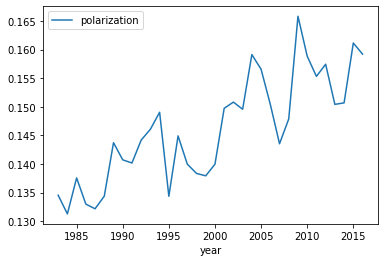

In [16]:
Result_DF.groupby('year',as_index=False).polarization.mean().plot(x='year',y='polarization')

In [45]:
# Normalize values
Null_DF['polarization_st'] = Null_DF.groupby('iter').polarization.transform(lambda x: (x-x.mean())/x.std())
Null_DF['partisanship_st'] = Null_DF.groupby('iter').partisanship.transform(lambda x: (x-x.mean())/x.std())

Result_DF['polarization_st'] = Result_DF.polarization.transform(lambda x: (x-x.mean())/x.std())
Result_DF['partisanship_st'] = Result_DF.partisanship.transform(lambda x: (x-x.mean())/x.std())

Null_DF['type'] = 'null'
Result_DF['iter'] = 99
Result_DF['type'] = 'true'

Null_DF = Null_DF[['type','iter','year','topic','distance','polarization','polarization_st','partisanship','partisanship_st']]
Result_DF = Result_DF[['type','iter','year','topic','distance','polarization','polarization_st','partisanship','partisanship_st']]

combined = pd.concat([Result_DF,Null_DF])

combined.to_csv('Results/True_and_Nulls_Frame.csv')

In [8]:
Result_DF.to_csv('Results/frame_polarizatio_true_results.csv')

In [7]:
corr_df = []
for r in Results:
    df = r['correlations']
    df['year'] = r['year']
    df['topic'] = r['topic']
    corr_df.append(df)
corr_df = pd.concat(corr_df)

corr_df.to_csv('Results/term_correlations_frames.csv')

## Preparing dataframe for ranked topics and terms

In [9]:
def get_top_terms(row):
    year = row['year']
    topic = row['topic']
    sub_corr = corr_df.loc[(corr_df.year == year) & (corr_df.topic == topic)]
    sub_corr = sub_corr.sort_values(by='correlation')
    Dem_ = sub_corr.head(5)
    Dem_score = Dem_.correlation.abs().mean()
    Rep_ = sub_corr.tail(5)
    Rep_score = Rep_.correlation.abs().mean()
    
    Rep_terms = ', '.join(list(Rep_.term)[::-1])
    Dem_terms = ', '.join(list(Dem_.term))
    return Rep_terms,Dem_terms,Rep_score,Dem_score

In [10]:
Result_DF = Result_DF.loc[-Result_DF.topic.isin(['armenian_genocide','tribute','procedural'])]
Result_DF.loc[Result_DF.topic == 'health_insurance','topic'] = 'healthcare'

df = Result_DF.sort_values(['year','distance'],ascending=[1,0]).groupby('year').head(3)[['distance','year','topic']]
df[['Rep_terms','Dem_terms','Rep_strength','Dem_strength']] = df.apply(get_top_terms,1,result_type="expand")
df['rank'] = [1,2,3] * 34

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [11]:
df

,distance,year,topic,Rep_terms,Dem_terms,Rep_strength,Dem_strength,rank
29,0.330601,1983,space,"century, recognition, 98th_congress, heritage,...","full, form, amount, future, service",0.264990,0.274741,1
19,0.297887,1983,veterans,"generation, turn, choose, blind, primary","first, request, conduct, numerous, vital",0.228684,0.254640,2
28,0.279639,1983,natural_resources_water,"relief, folk, movement, range, general","natural_resource, evaluation, understanding, d...",0.237923,0.187668,3
46,0.321589,1984,small_business,"seem, sector, choose, corporate, direction","suffer, strike, only, evin, open",0.305096,0.213819,1
33,0.278669,1984,social_security,"barber_conable, organization, tradition, read,...","cut, reinstate, die, fiscal_year, individual",0.240922,0.220953,2
...,...,...,...,...,...,...,...,...
1121,0.426732,2015,healthcare,,,NaN,NaN,2
1127,0.382390,2015,national_debt,"spending, taxis, simple, national_debt, balance","clean, pell_grant, affordable, refinance, college",0.328072,0.303822,3
1156,0.492861,2016,abortion,"prolife, life, unborn, violate, human","safe, attempt, reproductive_health, women, per...",0.358986,0.487873,1
1153,0.480509,2016,guns,"executive_order, overreach, executive, secure_...","gun_violence, today, orlando, house, republican",0.338362,0.300540,2


In [12]:
df.to_csv('Results/top_topics_and_terms.csv')